In [1]:
ZONE = "new_forest"
# Change this to False to re-download crops as part of this notebook.
CROPS_ALREADY_DOWNLOADED = True

In [2]:
# Load environment variables to download images.
# This defines the following environment variables:
# COPERNICUS_LOGIN, COPERNICUS_PASSWORD, AWS_SECRET_ACCESS_KEY, AWS_ACCESS_KEY_ID
import json
import os

with open("../env_vars.json", "r") as file:
    env_vars = json.load(file)
    for k, v in env_vars.items():
        os.environ[k] = v

In [3]:
%matplotlib inline

import sys
import os
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tsd
import geojson
import json
import folium
import rasterio, rasterio.mask
from PIL import Image, ImageDraw, ImageFont

sys.path.append("../forestry_yield_estimation")
import vistools, utils
from preprocessing import read_images, read_raw_points_data, get_catalog, get_aoi
from scraping import load_paysandu_weather

pd.options.mode.chained_assignment = None
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.4)

root = Path("..")
data_path = root / "data"
output_path = Path("../report/img")

In [ ]:
aoi = get_aoi(data_path, ZONE)
aoi_utm = get_aoi(data_path, ZONE, convert_to_utm=True)
aoi

In [5]:
fm = vistools.foliummap()
folium.GeoJson(aoi).add_to(fm)
fm.location = aoi["center"][::-1]

#fm

In [6]:
# Normalization
montenativo = (
    pd.read_csv(data_path/"montenativo.csv")
    .rename(columns=lambda col: f"montenativo_{col.split('_')[0]}" if "backscatter" in col else col)
)
montenativo

,date,polarisation,montenativo_mean,montenativo_median
0,2017-01-04,vh,2.787501,4.521789
1,2017-01-04,vv,3.109831,5.068904
2,2017-01-16,vh,2.742425,4.442651
3,2017-01-16,vv,3.082079,5.010635
4,2017-01-28,vh,2.622059,4.219508
...,...,...,...,...
227,2021-03-08,vv,2.995051,4.867535
228,2021-03-20,vh,2.631505,4.248495
229,2021-03-20,vv,2.993207,4.867535
230,2021-04-01,vh,2.616556,4.219508


In [7]:
catalog = get_catalog(data_path, ZONE, download_crops=not CROPS_ALREADY_DOWNLOADED, start_date="2017-01-01", end_date="2021-04-10")

Found 116 images


In [8]:
catalog["date_str"] = catalog["date"].dt.date.astype("str")
df = montenativo.merge(catalog, left_on=["date", "polarisation"], right_on=["date_str", "polarisation"], suffixes=(None, "_y"))[["date", "polarisation", "montenativo_mean", "montenativo_median", "filename"]]
df["date"] = pd.to_datetime(df["date"])
df

,date,polarisation,montenativo_mean,montenativo_median,filename
0,2017-01-04,vh,2.787501,4.521789,2017-01-04_S1B_orbit_170_D_GRD_vh
1,2017-01-04,vv,3.109831,5.068904,2017-01-04_S1B_orbit_170_D_GRD_vv
2,2017-01-16,vh,2.742425,4.442651,2017-01-16_S1B_orbit_170_D_GRD_vh
3,2017-01-16,vv,3.082079,5.010635,2017-01-16_S1B_orbit_170_D_GRD_vv
4,2017-01-28,vh,2.622059,4.219508,2017-01-28_S1B_orbit_170_D_GRD_vh
...,...,...,...,...,...
227,2021-03-08,vv,2.995051,4.867535,2021-03-08_S1B_orbit_170_D_GRD_vv
228,2021-03-20,vh,2.631505,4.248495,2021-03-20_S1B_orbit_170_D_GRD_vh
229,2021-03-20,vv,2.993207,4.867535,2021-03-20_S1B_orbit_170_D_GRD_vv
230,2021-04-01,vh,2.616556,4.219508,2021-04-01_S1B_orbit_170_D_GRD_vh


In [9]:
raw_images, filenames, srcs = read_images(data_path, ZONE)
assert list(filenames) == df["filename"].tolist()

images = np.log(raw_images)
#df["unnormalized_backscatter"] = images.mean((1, 2))
#images = raw_images
is_vv = np.array([f.endswith("vv") for f in filenames])

norm = df["montenativo_mean"].values
images = images - norm.reshape(-1, 1, 1)

images_8bit = np.empty_like(images, dtype="uint8")
images_8bit[is_vv] = utils.simple_equalization_8bit(images[is_vv])
images_8bit[~is_vv] = utils.simple_equalization_8bit(images[~is_vv])

  0%|          | 0/232 [00:00<?, ?it/s]

In [10]:
weather = load_paysandu_weather(data_path)
weather.index = weather.index.map(str)
weather_dict = weather.T.to_dict()

# Interactive visualization

In [11]:
from IPython.display import Image, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image

def display_image(img_index, vv=True):
    mask = (is_vv == vv)
    display(Image.fromarray(images_8bit[mask][img_index]))
    filename = filenames[mask][img_index]
    display(filename)
    w = weather_dict.get(filename[:10], "No data")
    display(w)

applet = interactive(
    display_image,
    img_index=widgets.IntSlider(min=0, max=115, step=1, value=10, layout=widgets.Layout(width="100%")),
    vv=True
)
applet.layout.height = "550px"
applet

interactive(children=(IntSlider(value=10, description='img_index', layout=Layout(width='100%'), max=115), Chec…

# Measurement

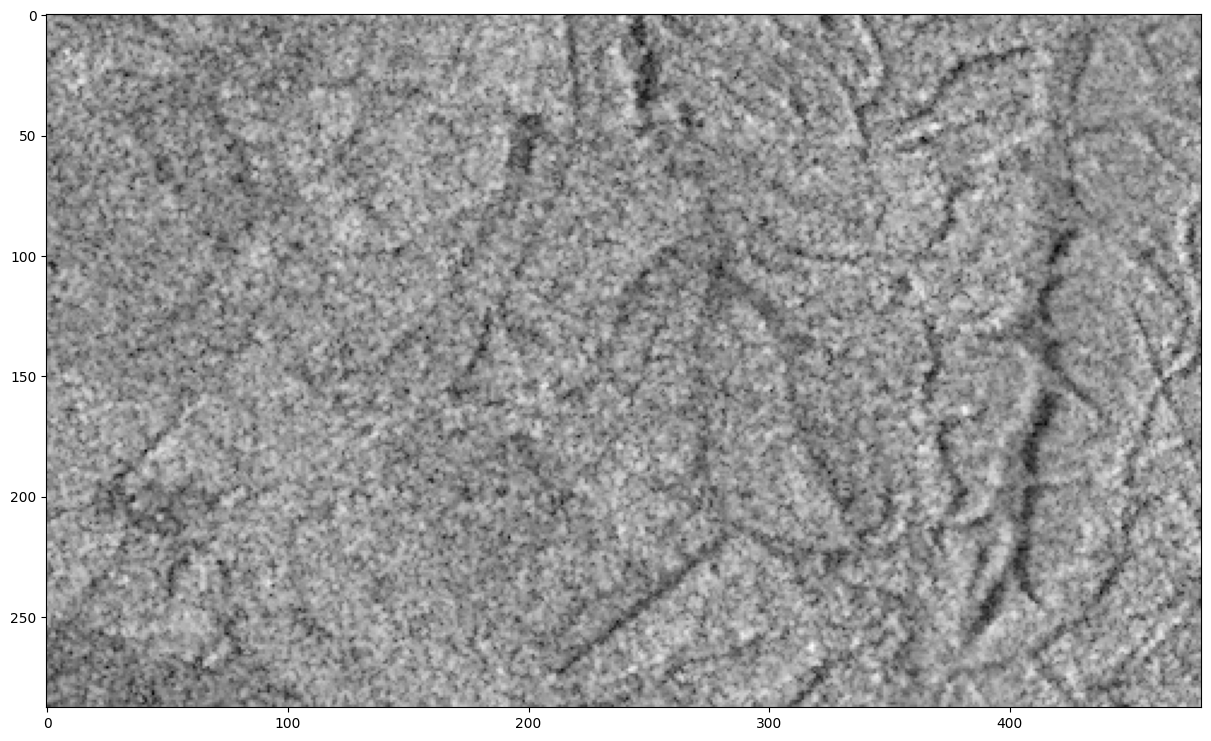

In [12]:
with plt.style.context("default"):
    ratio = images.shape[2] / images.shape[1]
    plt.subplots(figsize=(ratio*9, 9))
    plt.imshow(images[0], cmap="gray")
    plt.savefig(output_path/"images"/"new_forest_image.png")

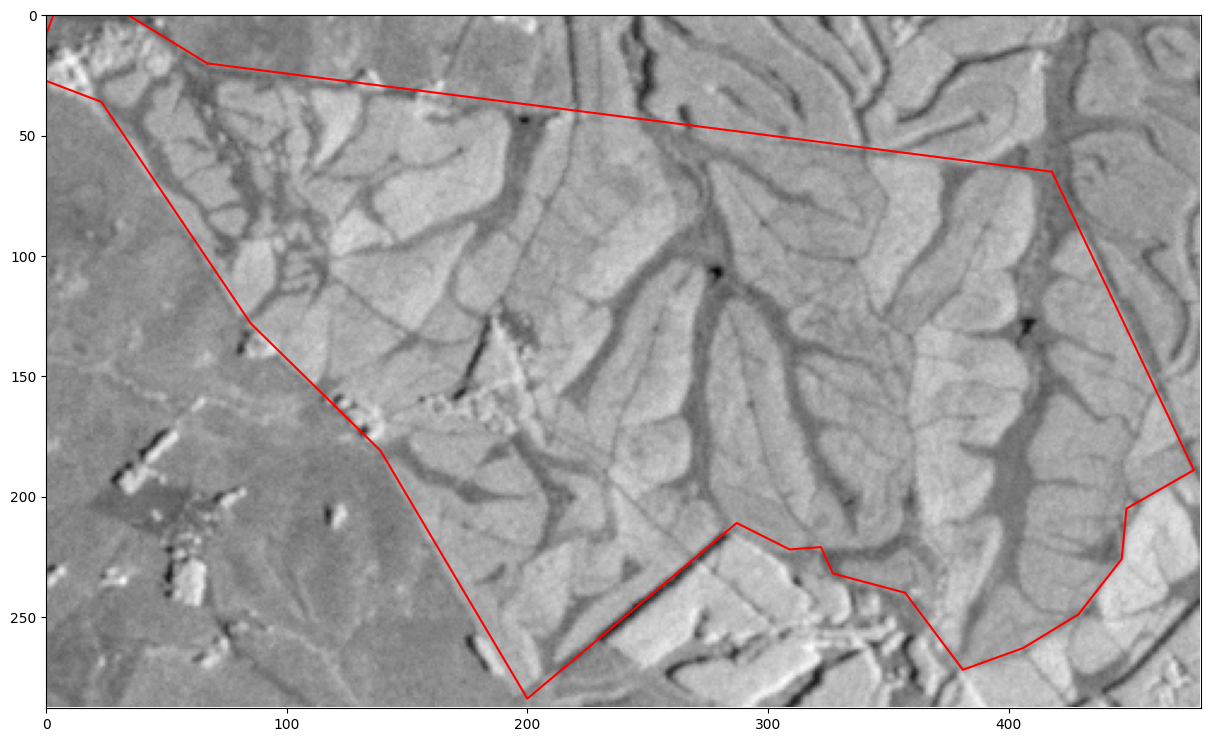

In [13]:
offset_correction = (-40, 20)
aoi_polygon = [
    [[easting + offset_correction[0], northing + offset_correction[1]] for easting, northing in sublist]
    for sublist in aoi_utm["coordinates"]
]

with plt.style.context("default"):
    plt.subplots(figsize=(ratio*9, 9))
    plt.imshow(np.median(images[:150], 0), cmap="gray")
    
    polygon = np.array([
        srcs[0].index(x, y)
        for x, y in aoi_polygon[0]
    ])
    plt.plot(polygon[:, 1], polygon[:, 0], c="red")
    plt.xlim(0, images.shape[2])
    plt.ylim(images.shape[1], 0)
plt.savefig(output_path/"polygons"/"new_forest_polygons.png")

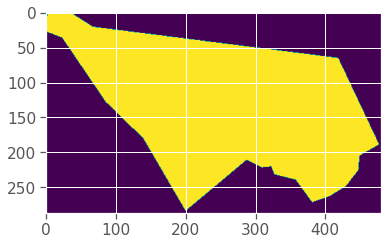

In [14]:
mask, _, _ = rasterio.mask.raster_geometry_mask(srcs[0], [geojson.Polygon(aoi_polygon)], invert=True)
plt.imshow(mask)

In [15]:
masks = np.repeat(mask[np.newaxis, ...], len(images), axis=0)
df["backscatter"] = (images * masks).mean((1, 2)) # Normalized
df["unnormalized_backscatter"] = df["backscatter"] + df["montenativo_mean"].values # Reconstruct the unnormalized means for comparison
if "rain" in df:
    df = df.drop(columns=["rain", "humidity"])
df = df.merge(weather.reset_index().assign(date=lambda w: pd.to_datetime(w.date)), on="date")
df

,date,polarisation,montenativo_mean,montenativo_median,filename,backscatter,unnormalized_backscatter,rain,humidity
0,2017-01-04,vh,2.787501,4.521789,2017-01-04_S1B_orbit_170_D_GRD_vh,0.928070,3.715571,16.800,0.8550
1,2017-01-04,vv,3.109831,5.068904,2017-01-04_S1B_orbit_170_D_GRD_vv,1.102223,4.212054,16.800,0.8550
2,2017-01-16,vh,2.742425,4.442651,2017-01-16_S1B_orbit_170_D_GRD_vh,0.890524,3.632949,1.525,0.9475
3,2017-01-16,vv,3.082079,5.010635,2017-01-16_S1B_orbit_170_D_GRD_vv,1.075261,4.157340,1.525,0.9475
4,2017-01-28,vh,2.622059,4.219508,2017-01-28_S1B_orbit_170_D_GRD_vh,0.767649,3.389707,0.000,0.7300
...,...,...,...,...,...,...,...,...,...
227,2021-03-08,vv,2.995051,4.867535,2021-03-08_S1B_orbit_170_D_GRD_vv,1.020327,4.015378,0.000,0.5850
228,2021-03-20,vh,2.631505,4.248495,2021-03-20_S1B_orbit_170_D_GRD_vh,0.928780,3.560285,0.000,0.7175
229,2021-03-20,vv,2.993207,4.867535,2021-03-20_S1B_orbit_170_D_GRD_vv,1.012718,4.005925,0.000,0.7175
230,2021-04-01,vh,2.616556,4.219508,2021-04-01_S1B_orbit_170_D_GRD_vh,0.934114,3.550671,0.000,0.7925


vv identity R² = 57%
vh identity R² = 47%


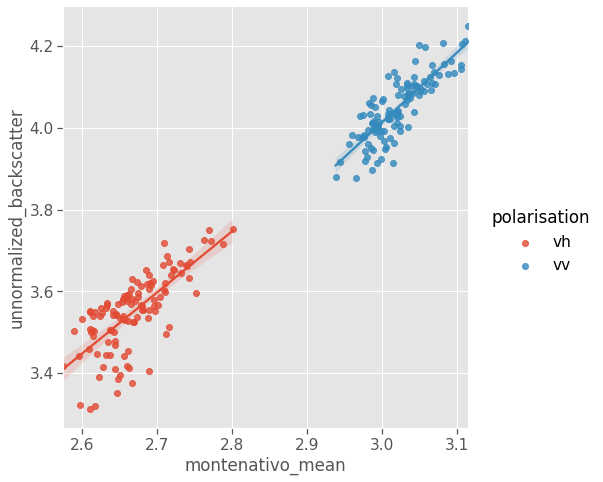

In [16]:
for pol in ["vv", "vh"]:
    data = df.query("polarisation == @pol")[["montenativo_mean", "unnormalized_backscatter"]]
    r_sq = 1 - (data["unnormalized_backscatter"] - data["montenativo_mean"]).var() / data["unnormalized_backscatter"].var()
    print(f"{pol} identity R² = {r_sq:.0%}")
g = sns.lmplot(data=df, x="montenativo_mean", y="unnormalized_backscatter", hue="polarisation", height=7)
g.tight_layout()
plt.savefig(output_path/"normalization"/"new_forest_correlation.png")

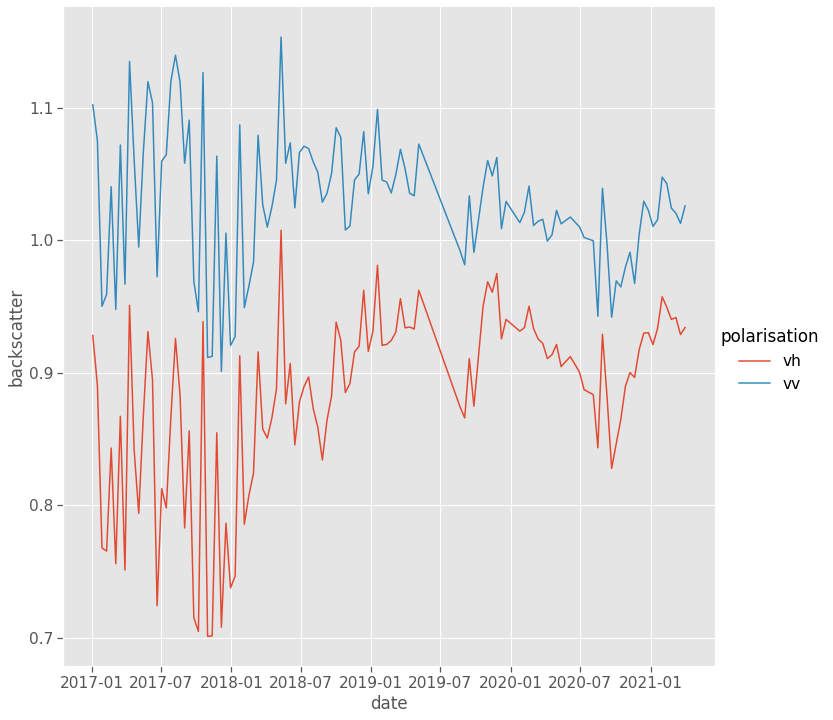

In [17]:
window_size = 1
for polarisation in ["vv", "vh"]:
    df.loc[df["polarisation"] == polarisation, "backscatter"] = df.loc[df["polarisation"] == polarisation, "backscatter"].rolling(window_size).mean()

g = sns.relplot(data=df, x="date", y="backscatter", hue="polarisation", height=10, kind="line")
plt.savefig(output_path/"new_forest"/"timeseries.png")

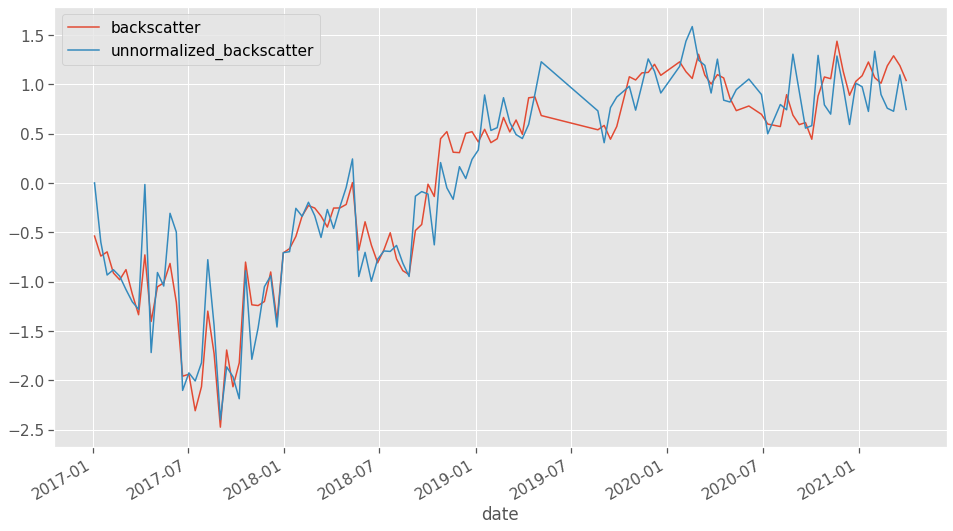

In [18]:
ratio = (
    df.set_index("date").loc[(df["polarisation"] == "vh").values, ["backscatter", "unnormalized_backscatter"]]
    - df.set_index("date").loc[(df["polarisation"] == "vv").values, ["backscatter", "unnormalized_backscatter"]]
)
((ratio - ratio.mean()) / ratio.std()).rolling(1, center=True).mean().plot(figsize=(16, 9))
plt.savefig(output_path/"new_forest"/"timeseries_ratio.png")

# Residual effect of weather

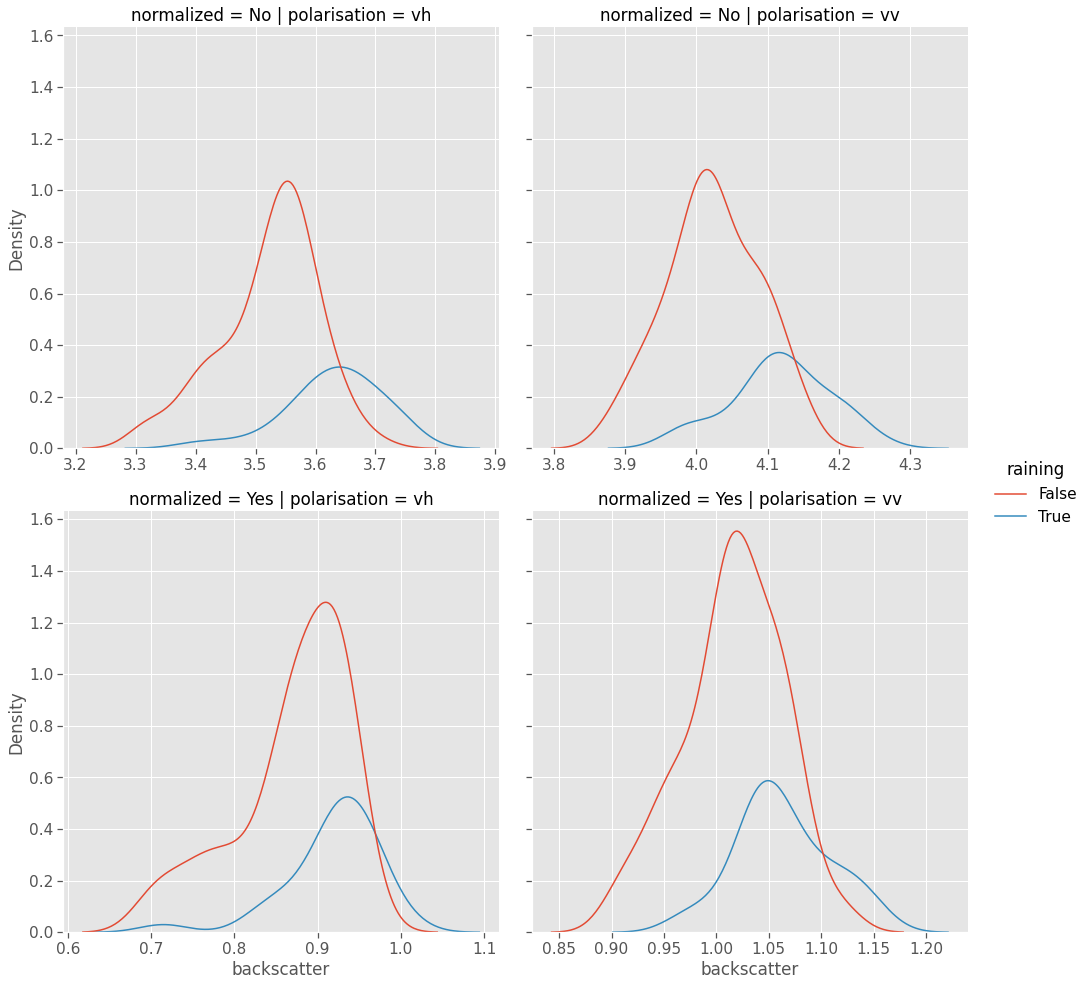

In [19]:
data = (
    df
    .assign(raining=lambda df: df.rain>0)
    .rename(columns={"unnormalized_backscatter": "No", "backscatter": "Yes"})
    .melt(id_vars=["raining", "polarisation"], value_vars=["Yes", "No"], var_name="normalized", value_name="backscatter")
)
sns.displot(
    data=data,
    x="backscatter",
    hue="raining",
    col="polarisation",
    row="normalized",
    kind="kde",
    row_order=["No", "Yes"],
    facet_kws=dict(sharex=False),
    height=7
)
plt.savefig(output_path/"normalization"/"new_forest_rain_effect.png")